In [ ]:
import pandas as pd   
# parquet_file = 'location\to\file\example_pa.parquet'
file = '../模型/WeatherDelay/WeatherDelay_Group30_dataset.parquet'
dataset = pd.read_parquet(file, engine='pyarrow');dataset

In [ ]:
dataset.groupby('WeatherDelayGroups30').size()

In [ ]:
#main
df = dataset.groupby('WeatherDelayGroups30').sample(n=7442, random_state=2)

#驗證
df['WeatherDelayGroups30'].value_counts()

In [ ]:
col_select =['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
# 'IATA_Code_Marketing_Airline', 
 'Airline_AA',
 'Airline_AS',
 'Airline_B6',
 'Airline_DL',
 'Airline_F9',
 'Airline_G4',
 'Airline_HA',
 'Airline_NK',
 'Airline_UA',
 'Airline_VX',
 'Airline_WN',
'Origin', 'Dest',
'CRSDepTime',
'CRSArrTime', 
'Distance',
'AWND',
'PRCP',
'TMAX',
'TMIN',
'WSF2',
'WSF5',
'SNOW',
'WT01',
'WT02',
'WT03',
'WT04',
'WT05',
'WT06',
'WT07',
'WT08',
'WT09',
'WT10',
'WT11',
'WT18',
'WeatherDelayGroups30']

df2 = df[col_select]

# y = dataset['ArrivalDelayGroups']
y = df2['WeatherDelayGroups30']
# X = dataset.loc[:, dataset.columns != 'ArrivalDelayGroups'] #select all columns but not the labels
X = df2.loc[:, ~df2.columns.isin(['ArrivalDelayGroups','ArrivalDelayGroups30','WeatherDelay','WeatherDelayGroups30'])]

#### NORMALIZE X ####

# Normalize so everything is on the same scale. 
from sklearn import preprocessing
cols = X.columns
# min_max_scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
# np_scaled = min_max_scaler.fit_transform(X)
np_scaled = scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)



## xgboost

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, y_train)

from sklearn.model_selection import GridSearchCV
import time
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb




# 開始運算時間
start = time.perf_counter()

params = {'objective': 'multi:softmax',
              'num_class': 7,
            #   'objective':'binary:logistic',    # 輸出概率
              'learning_rate': 0.01,    # 更新过程中用到的收缩步长 (0-1)
              'max_depth': 10,    # 树的最大深度 (1-無限)
              # 'min_child_weight': 10,    # 决定最小叶子节点样本权重和，加权和低于这个值时，就不再分裂产生新的叶子节点(0-無限)
              # 'subsample': 1,    # 这个参数控制对于每棵树，随机采样的比例 (0-1)
              # 'colsample_bytree': 0.6,    # 用来控制每颗树随机采样的列数的占比 (0-1)
              }    # 給定種子數，固定42


num_rounds = 1000
model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds)

# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)


end = time.perf_counter()
print(end - start)

import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
ax = xgb.plot_importance(model)
plt.rcParams['figure.figsize'] =[20,20]
fig = ax.get_figure()

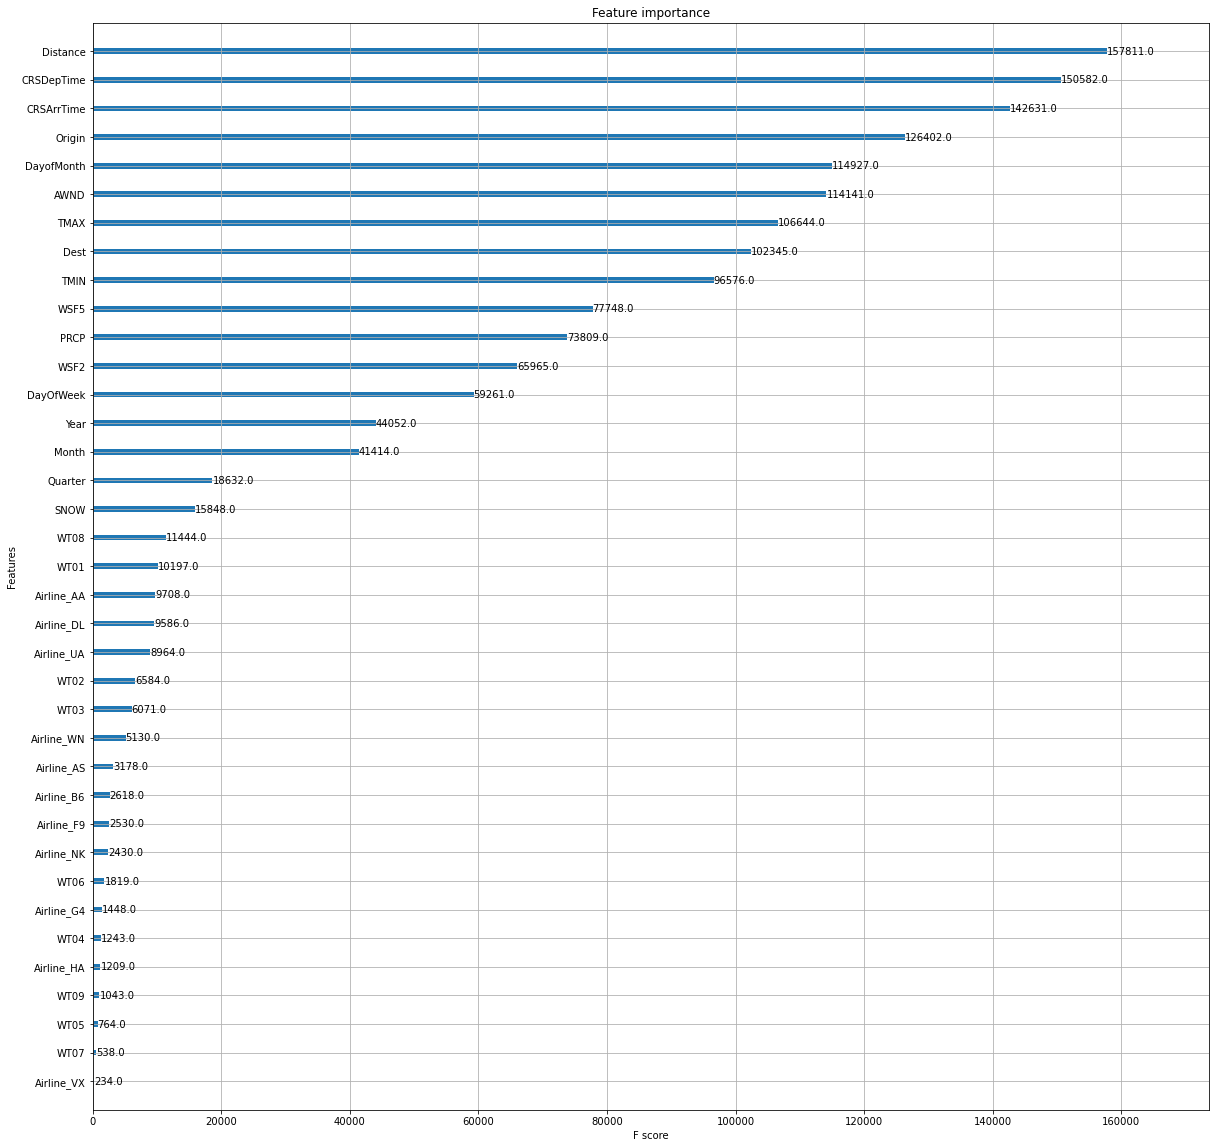

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
print('Accuracy', ':', round(accuracy_score(y_test, y_pred), 5), '\n')
print('Accuracy', ':', round(balanced_accuracy_score(y_test, y_pred), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, y_pred) #normalize = 'true'
plt.figure(figsize = (16, 9))
# plt.figure(figsize = (32, 18))

sns.heatmap(confusion_matr, cmap="YlGnBu", annot=True, fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


from sklearn.metrics import classification_report
# y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

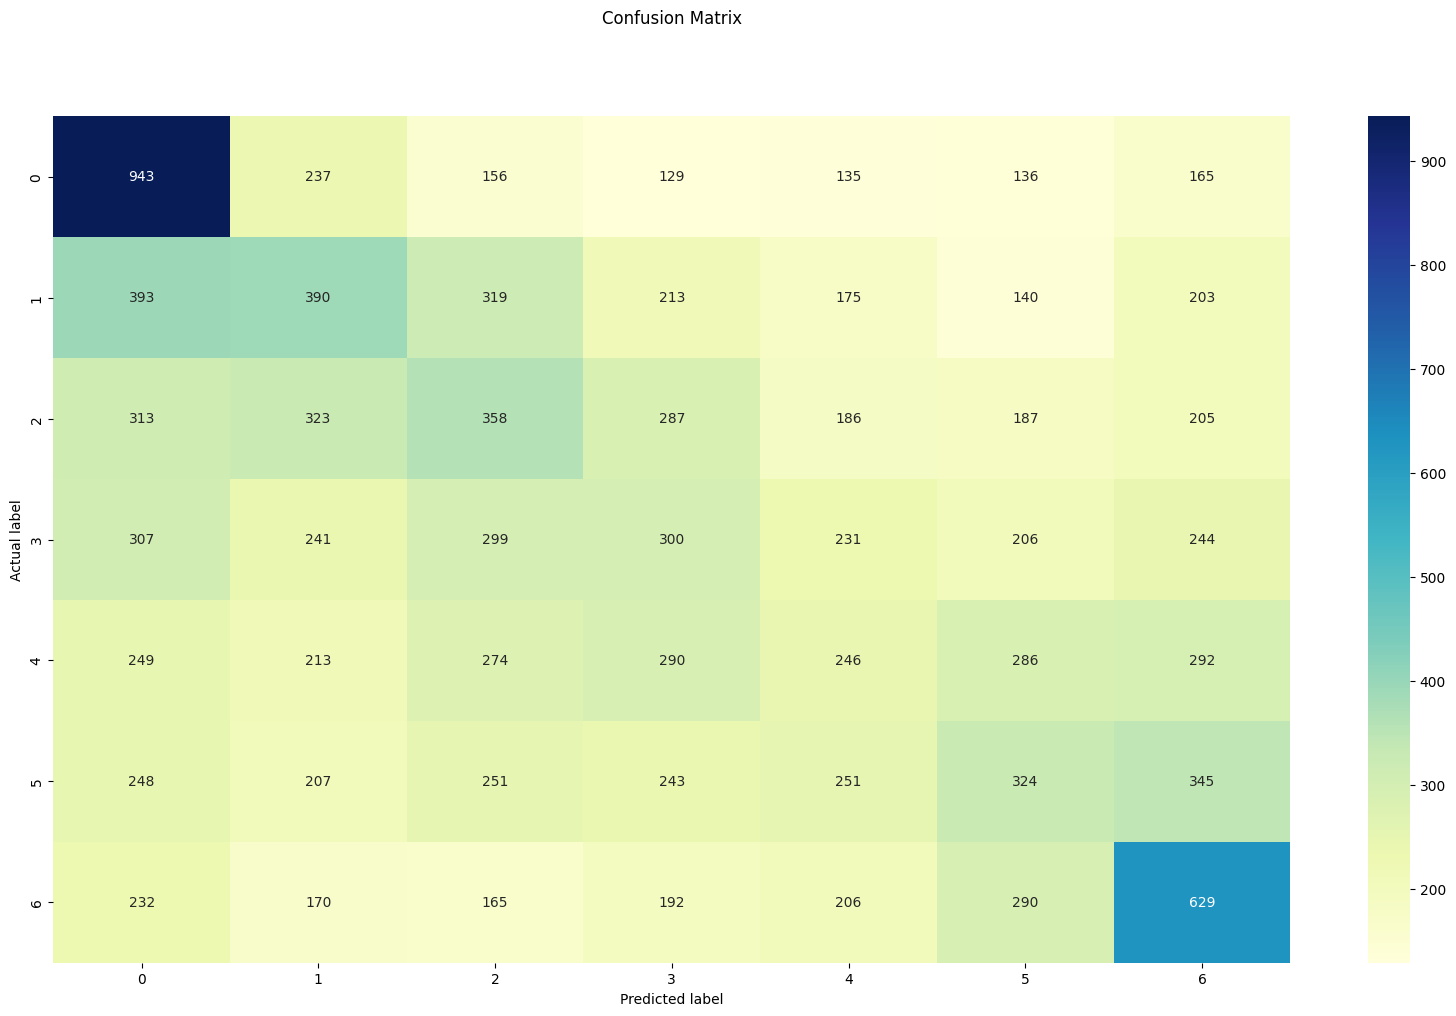